# Imports

In [33]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import json
import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

In [34]:
fs = 200
n_signals = 4
dataset = reader.load_dataset(constants.MASS_KC_NAME, params={pkeys.FS: fs})
stamps_kc = dataset.get_subset_stamps(dataset.all_ids[:n_signals], which_expert=1)
dataset = reader.load_dataset(constants.MASS_SS_NAME, params={pkeys.FS: fs})
stamps_ss_e1 = dataset.get_subset_stamps(dataset.all_ids[:n_signals], which_expert=1)
signals = dataset.get_subset_signals(dataset.all_ids[:n_signals], normalize_clip=True)
del dataset

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_kc with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


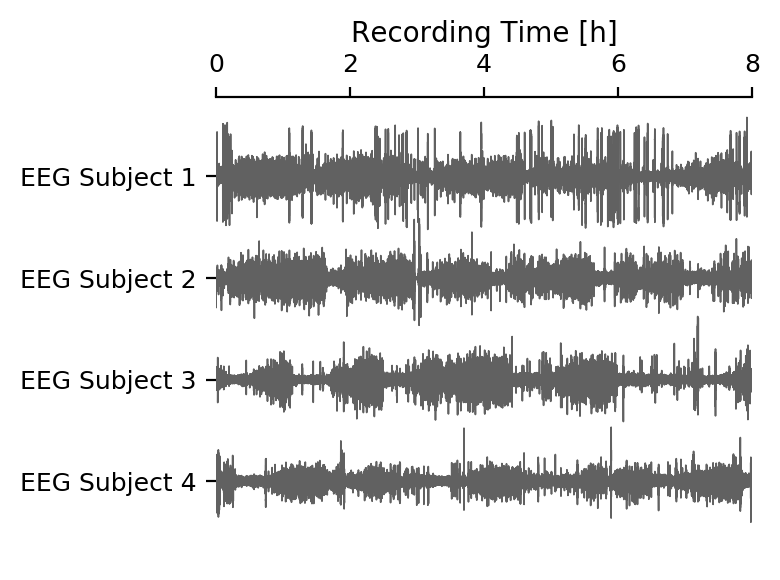

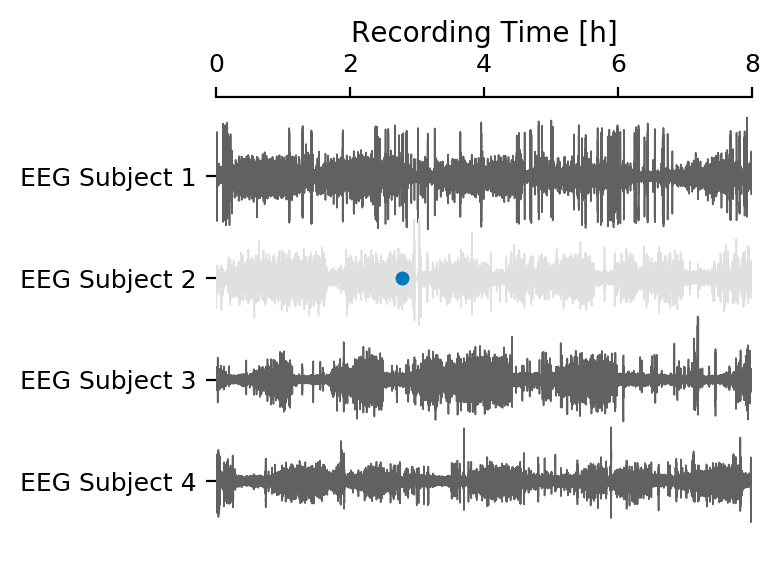

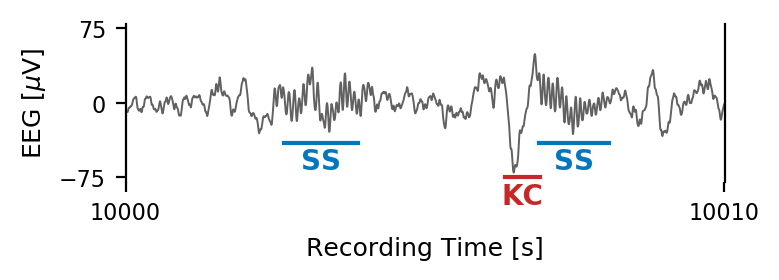

In [103]:
dpi = 200
signal_color = viz.GREY_COLORS[7]
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=dpi)
gap = 600
down = 4
for i in range(n_signals):
    s_signal = signals[i][::down] - gap * i
    time_axis = np.arange(s_signal.size) * down / fs
    time_axis_h = time_axis / 3600
    ax.plot(time_axis_h, s_signal, color=viz.GREY_COLORS[7], linewidth=0.6)
ax.set_xlim([0, 8])
ax.set_xticks([0, 2, 4, 6, 8])
ax.set_xlabel('Recording Time [h]', fontsize=10)
ax.set_yticks([-i*gap for i in range(4)])
ax.set_yticklabels(['EEG Subject %d' % (i+1) for i in range(4)])
ax.tick_params(labelsize=9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.tight_layout()
plt.show()

which_kc_stamp = 195# 230, 500
i_sel = 1
window_size = 10
central_sample = stamps_kc[i_sel][which_kc_stamp, :].mean()
start_sample = int(central_sample - window_size * fs / 2)
start_sample = int(int((start_sample / fs) / 10) * 10 * fs)
end_sample = int(start_sample + window_size * fs)

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=dpi)
gap = 600
down = 4
for i in range(n_signals):
    s_signal = signals[i][::down] - gap * i
    time_axis = np.arange(s_signal.size) * down / fs
    time_axis_h = time_axis / 3600
    if i == i_sel:
        signal_color = viz.GREY_COLORS[3]
    else:
        signal_color = viz.GREY_COLORS[7]
    ax.plot(time_axis_h, s_signal, color=signal_color, linewidth=0.6)
    if i == i_sel:
        ax.plot(
            (start_sample + end_sample) / (2 * fs * 3600), - gap * i,
            marker='o', markersize=4, color=viz.PALETTE['blue'])
ax.set_xlim([0, 8])
ax.set_xticks([0, 2, 4, 6, 8])
ax.set_xlabel('Recording Time [h]', fontsize=10)
ax.set_yticks([-i*gap for i in range(4)])
ax.set_yticklabels(['EEG Subject %d' % (i+1) for i in range(4)])
ax.tick_params(labelsize=9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.tight_layout()
plt.show()


which_kc_stamp = 195# 230, 500
i_sel = 1
window_size = 10
central_sample = stamps_kc[i_sel][which_kc_stamp, :].mean()
start_sample = int(central_sample - window_size * fs / 2)
start_sample = int(int((start_sample / fs) / 10) * 10 * fs)
end_sample = int(start_sample + window_size * fs)
s_signal = signals[i_sel][start_sample:end_sample]
segment_stamps_ss = utils.filter_stamps(stamps_ss_e1[i_sel], start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc[i_sel], start_sample, end_sample)

fig, ax = plt.subplots(1, 1, figsize=(4, 1.5), dpi=dpi)
time_axis = np.arange(start_sample, end_sample) / fs
ax.plot(time_axis, s_signal, color=viz.GREY_COLORS[7], linewidth=0.7)
ss_value = -40
kc_value = -75
for ss in segment_stamps_ss:
    ax.plot(ss/fs, [ss_value, ss_value], color=viz.PALETTE['blue'])
    ax.text(
        ss.mean()/fs, ss_value-5, 'SS', 
        horizontalalignment='center', verticalalignment='top', 
        color=viz.PALETTE['blue'], weight='bold')
for ss in segment_stamps_kc:
    ax.plot(ss/fs, [kc_value, kc_value], color=viz.PALETTE['red'])
    ax.text(
        ss.mean()/fs, kc_value-5, 'KC', 
        horizontalalignment='center', verticalalignment='top', 
        color=viz.PALETTE['red'], weight='bold')
ax.set_xlim([start_sample/fs, end_sample/fs])
ax.set_xticks([start_sample/fs, end_sample/fs])
ax.set_ylim([-80, 80])
ax.set_yticks([-75, 0, 75])
ax.set_ylabel(r'EEG [$\mu$V]', fontsize=9)
ax.set_xlabel('Recording Time [s]', fontsize=9)
ax.tick_params(labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

In [35]:
which_kc_stamp = 195# 230, 500
i_sel = 1
window_size = 10
central_sample = stamps_kc[i_sel][which_kc_stamp, :].mean()
start_sample = int(central_sample - window_size * fs / 2)
#start_sample = int(int((start_sample / fs) / 10) * 10 * fs)
end_sample = int(start_sample + window_size * fs)
s_signal = signals[i_sel][start_sample:end_sample]
segment_stamps_ss = utils.filter_stamps(stamps_ss_e1[i_sel], start_sample, end_sample)
segment_stamps_kc = utils.filter_stamps(stamps_kc[i_sel], start_sample, end_sample)

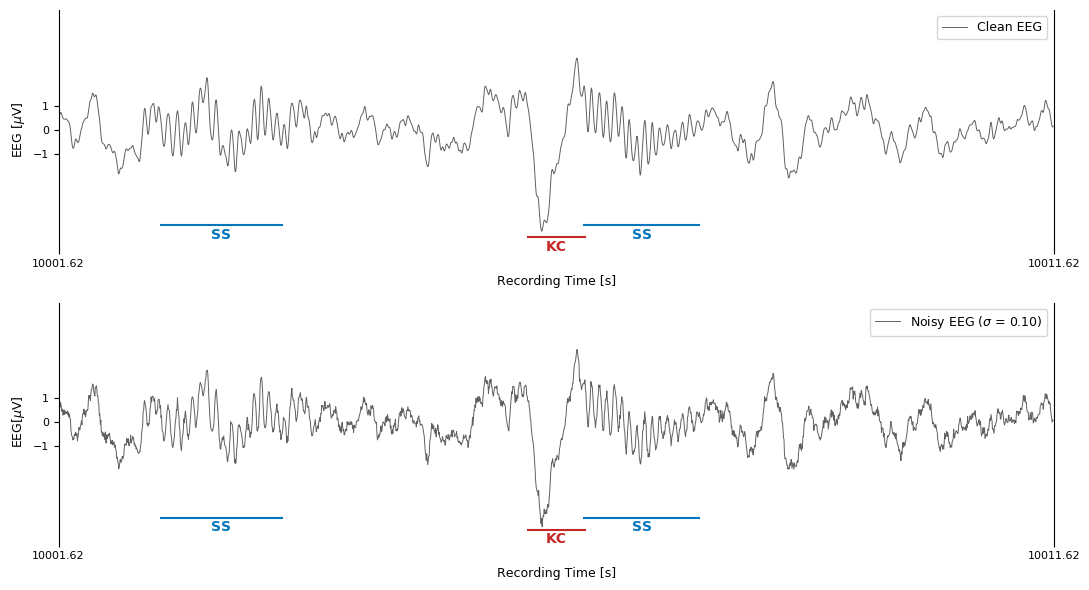

In [77]:
noise_std = 0.1 # std [0.05, 0.1, 0.2, 0.3] x p [0.5, 1.0]
n_samples = s_signal.size
gaussian_noise = np.random.normal(scale=noise_std, size=n_samples)

fig, axes = plt.subplots(2, 1, figsize=(11, 6), dpi=100)
time_axis = np.arange(start_sample, end_sample) / fs


ax = axes[0]
ax.plot(time_axis, s_signal, color=viz.GREY_COLORS[7], linewidth=0.7, label="Clean EEG")
ss_value = -4
kc_value = -4.5
for ss in segment_stamps_ss:
    ax.plot(ss/fs, [ss_value, ss_value], color=viz.PALETTE['blue'])
    ax.text(
        ss.mean()/fs, ss_value-0.1, 'SS', 
        horizontalalignment='center', verticalalignment='top', 
        color=viz.PALETTE['blue'], weight='bold')
for ss in segment_stamps_kc:
    ax.plot(ss/fs, [kc_value, kc_value], color=viz.PALETTE['red'])
    ax.text(
        ss.mean()/fs, kc_value-0.1, 'KC', 
        horizontalalignment='center', verticalalignment='top', 
        color=viz.PALETTE['red'], weight='bold')
ax.set_xlim([start_sample/fs, end_sample/fs])
ax.set_xticks([start_sample/fs, end_sample/fs])
ax.set_ylim([-5, 5])
ax.set_yticks([-1, 0, 1])
ax.set_ylabel(r'EEG [$\mu$V]', fontsize=9)
ax.set_xlabel('Recording Time [s]', fontsize=9)
ax.tick_params(labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(fontsize=9, loc="upper right")

ax = axes[1]
ax.plot(
    time_axis, s_signal + gaussian_noise, color=viz.GREY_COLORS[7], linewidth=0.7, 
    label="Noisy EEG ($\sigma$ = %1.2f)" % noise_std)
ss_value = -4
kc_value = -4.5
for ss in segment_stamps_ss:
    ax.plot(ss/fs, [ss_value, ss_value], color=viz.PALETTE['blue'])
    ax.text(
        ss.mean()/fs, ss_value-0.1, 'SS', 
        horizontalalignment='center', verticalalignment='top', 
        color=viz.PALETTE['blue'], weight='bold')
for ss in segment_stamps_kc:
    ax.plot(ss/fs, [kc_value, kc_value], color=viz.PALETTE['red'])
    ax.text(
        ss.mean()/fs, kc_value-0.1, 'KC', 
        horizontalalignment='center', verticalalignment='top', 
        color=viz.PALETTE['red'], weight='bold')
ax.set_xlim([start_sample/fs, end_sample/fs])
ax.set_xticks([start_sample/fs, end_sample/fs])
ax.set_ylim([-5, 5])
ax.set_yticks([-1, 0, 1])
ax.set_ylabel(r'EEG[$\mu$V]', fontsize=9)
ax.set_xlabel('Recording Time [s]', fontsize=9)
ax.tick_params(labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(fontsize=9, loc="upper right")

plt.tight_layout()
plt.show()